# template notebook to be expanded
 * add description here
 
### general information about the different growth/respiration versions

 * for the functional form of the different size-dependent growth and respiration formulations see [this notebook](sizedep_formulations.ipynb) 

## load data from files and plot

In [1]:
#%matplotlib notebook
import netCDF4 as nc4
import numpy as np
import pandas as pd
import dateutil.parser

# create plots of the data
show_data = False

# load data
datafiles = {
    #'seaflow':'data/SeaFlow_SizeDist_regrid-25-8.nc',
    'zinser':'data/Zinser_SizeDist_calibrated-26-6.nc',
}

itestfiles = {
    'seaflow':'data/Zinser_SizeDist_calibrated-26-6-itest.csv', # same as zinser
    'zinser':'data/Zinser_SizeDist_calibrated-26-6-itest.csv',         
}

desc = {
    'seaflow':'SeaFlow dataset',
    'zinser':'Zinser dataset',    
}

data_gridded = {}
for dataname in datafiles:
    data_gridded[dataname] = {}
    with nc4.Dataset(datafiles[dataname]) as nc:
        for var in nc.variables:
            data_gridded[dataname][var] = nc.variables[var][:]
    desc[dataname] += ' (m={data[m]}, $\Delta_v^{{-1}}$={data[delta_v_inv]})'.format(data=data_gridded[dataname])

# Now we load in count data
for dataname in datafiles:

    if 'seaflow' in dataname:
        # Extract SeaFlow cell counts
        seaflow = pd.read_csv('data/SeaFlow_PSD_hourlyCOUNT_m32.csv')
        seaflow_counts = seaflow.values[:, 2:].T.astype(int)

        # Redefine parameters to match 32-size class count data. We only keep PAR from the 25-size class data.
        data_gridded[dataname]['m'] = seaflow_counts.shape[0]
        data_gridded[dataname]['size_bounds'] = seaflow.columns[2:].values.astype(float) # extract size classes from dataframe
        data_gridded[dataname]['v_min'] = data_gridded[dataname]['size_bounds'][0] # note these seem to be on a different scale
        data_gridded[dataname]['delta_v_inv'] = int(np.round(1.0/np.log2(data_gridded[dataname]['size_bounds'][1]/data_gridded[dataname]['size_bounds'][0])))
        data_gridded[dataname]['w_obs'] = (seaflow_counts/np.sum(seaflow_counts, axis=0)[None, :]).astype(float)
        data_gridded[dataname]['counts'] = seaflow_counts
        data_gridded[dataname]['obs_time'] = np.empty(shape=seaflow_counts.shape[1])

        # Extract time stamps for each observation from SeaFlow data
        ii = 0
        for timestamp in np.asarray(seaflow['time'], dtype=str):
            datetime = dateutil.parser.isoparse(timestamp)
            if ii == 0:
                initial = datetime
            data_gridded['seaflow']['obs_time'][ii] = (datetime - initial).total_seconds()/60
            ii += 1

    elif 'zinser' in dataname:

        # Extract Zinser cell counts
        zinser = pd.read_csv('data/Zinser_Figure2A.csv')
        #zinser_counts = zinser.values[:,1].astype(int) # cells A column
        #zinser_counts = zinser.values[:,2].astype(int) # cells B column
        zinser_counts = np.mean(zinser.values, axis=1).astype(int) # mean of both columns
        
        # Add counts to Zinser data
        data_gridded[dataname]['counts'] = (data_gridded[dataname]['w_obs'] * zinser_counts).astype(int)
        data_gridded[dataname]['obs_time'] = data_gridded[dataname]['time']

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

if show_data:
    for i,dataname in enumerate(data_gridded):
        nrows = 3
        sharex = np.array_equal(data_gridded[dataname]['time'], data_gridded[dataname]['obs_time'])

        v_min = data_gridded[dataname]['v_min']
        delta_v = 1.0/data_gridded[dataname]['delta_v_inv']
        v = v_min * 2**(np.arange(data_gridded[dataname]['m'])*delta_v) 

        fig,axs = plt.subplots(nrows=nrows, sharex=sharex, figsize=(12,4*nrows))

        ax = axs[0]
        ax.set_title('raw '+desc[dataname], size=20)
        ax.plot(data_gridded[dataname]['time'], data_gridded[dataname]['PAR'], color='gold')
        ax.set(ylabel='PAR')

        ax = axs[1]
        pc = ax.pcolormesh(data_gridded[dataname]['obs_time'],v,data_gridded[dataname]['w_obs'])
        ax.set(ylabel='size ($\mu$m$^3$)')
        #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

        ax = axs[2]
        pc = ax.pcolormesh(data_gridded[dataname]['obs_time'],v,data_gridded[dataname]['counts'])
        ax.set(ylabel='size ($\mu$m$^3$)')
        #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='counts')
    axs[-1].set_xlabel=('time (minutes)')
None

## process data and plot it

In [3]:
# prepare data for Stan model

if 'data' not in globals():
    data = {}
if 'mcmcs' not in globals():
    mcmcs = {}
if 'models' not in globals():
    models = {}

for dataname in data_gridded:
    dt = 20 # in units of minutes
    
    data[dataname] = {'dt':dt}
    for v in ('m','v_min','delta_v_inv'):
        data[dataname][v] = data_gridded[dataname][v]

    if 'seaflow' in dataname:
        limit_days = 1
        data[dataname]['obs'] = data_gridded[dataname]['w_obs']
        data[dataname]['t_obs'] = data_gridded[dataname]['obs_time']
                
        # median filter PAR
        # see: medianfilter_par.ipynb
        n = len(data_gridded[dataname]['PAR'])
        wsh = 30 # half of median filter window size; window size is 2*wsh+1
        par = np.array([np.median(data_gridded[dataname]['PAR'][max(0,i-wsh):min(n,i+wsh+1)]) for i in range(n)])
    else:
        limit_days = 2
        
        data[dataname]['obs'] = data_gridded[dataname]['w_obs']
        data[dataname]['t_obs'] = data_gridded[dataname]['obs_time']
        par = data_gridded[dataname]['PAR']
        
    if limit_days > 0:
        limit_minutes = limit_days*1440
        
        ind_obs = data[dataname]['t_obs'] < limit_minutes
        data[dataname]['t_obs'] = data[dataname]['t_obs'][ind_obs]
        data[dataname]['obs'] = data[dataname]['obs'][:,ind_obs]
        
        data[dataname]['nt'] = int(limit_minutes//data[dataname]['dt'])

    data[dataname]['nt_obs'] = data[dataname]['t_obs'].size
    
    # set all indices to zero
    data[dataname]['i_test'] = np.zeros(data[dataname]['nt_obs'], dtype=int)
    # load cross-validation testing indices and add them to data
    #data[dataname]['i_test'] = np.loadtxt(itestfiles[dataname]).astype(int)
    
    # switch on or off data fitting
    data[dataname]['prior_only'] = 0
    
    # add light data
    t = np.arange(data[dataname]['nt'])*data[dataname]['dt']
    data[dataname]['E'] = np.interp(t, xp=data_gridded[dataname]['time'], fp=par)
    
    # real count data
    data[dataname]['obs_count'] = data_gridded[dataname]['counts'][:, ind_obs]
    
    # consistency check
    if len(data[dataname]['i_test']) != data[dataname]['nt_obs']:
        raise ValueError('Invalid number of testing indices for "{}" (expected {}, got {}).'.format(dataname,data[dataname]['nt_obs'],len(data[dataname]['i_test'])))

In [4]:
if show_data:
    for i,dataname in enumerate(data):
        nrows = 3

        v_min = data[dataname]['v_min']
        delta_v = 1.0/data[dataname]['delta_v_inv']
        v = v_min * 2**(np.arange(data[dataname]['m'])*delta_v) 
        t = np.arange(data[dataname]['nt'])*data[dataname]['dt']


        fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))

        ax = axs[0]
        ax.set_title('processed '+desc[dataname], size=20)
        ax.plot(t, data[dataname]['E'], color='gold')
        ax.set(ylabel='E')

        ax = axs[1]
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,data[dataname]['obs'])
        ax.set(ylabel='size ($\mu$m$^3$)')
        #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
        ax.set_xlim(left=0.0)

        ax = axs[2]
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,data[dataname]['obs_count'])
        ax.set(ylabel='size ($\mu$m$^3$)')
        #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='counts')
        ax.set_xlim(left=0.0)
    axs[-1].set_xlabel('time (minutes)')
None

## run model

In [5]:
import pystan
import re

desc_model = {
    #'s1':'m1',
    #'s2':'m2',
    #'s3':'m3',
    #'s4':'m4',
    's5':'m5',
    #'s6':'m6',
    #'s7':'m7',
    #'s8':'m8',
    's9':'m9',
    #'s10':'m10',
    #'s11':'m5 + size-dep growth (m5-m6 hybrid)',
    #'s12':'m5 + size-dep growth (m5-m7 hybrid)',
}
# preparing for some regular expression magic
model_code_replacements = {
    's1':(),
    's2':(),
    's3':(),
    's4':(),
    's5':(),
    's6':(),
    's7':(),
    's8':(),
    's9':(),
    's10':(),
    's11':(),
    's12':(),
}
model_stan_key = {
    's1':'c1',
    's2':'c2',
    's3':'c3',
    's4':'c4',
    's5':'c5',
    's6':'c6',
    's7':'c7',
    's8':'c8',
    's9':'c9',
    's10':'c10',
    's11':'c56',
    's12':'c57',
}
stan_files = {
    'c1':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_freedelta_normparam_trackgrowth_xval2.stan',
    'c2':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2_normparam_trackgrowth_xval2.stan',
    'c3':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2_gammaiv6_normparam_trackgrowth_xval2.stan',
    'c4':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respv1_normparam_trackgrowth_xval2.stan',
    'c5':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respv2_normparam_trackgrowth_xval2.stan',
    'c6':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respiv6_normparam_trackgrowth_xval2.stan',
    'c7':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respiv7_normparam_trackgrowth_xval2.stan',
    'c8':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respiv6_normparam_trackgrowth_xval2.stan',
    'c9':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respiv7_normparam_trackgrowth_xval2.stan',
    'c10':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respv2_normparam_trackgrowth_xval2.stan',
    'c56':'stancode/matrixmodel_mlmultinom_estinilnorm2_monodelta2_resp_gammaiv6_normparam_trackgrowth_xval2.stan',
    'c57':'stancode/matrixmodel_mlmultinom_estinilnorm2_monodelta2_resp_gammaiv7_normparam_trackgrowth_xval2.stan',
}

refit_required = {}
stan_base_code = {}
for key,stan_file in stan_files.items():
    with open(stan_file) as f:
        stan_base_code[key] = f.read()

stan_code = {}
for model in desc_model:
    code_split = stan_base_code[model_stan_key[model]].split('\n')
    code_split_new = []
    for line in code_split:
        line_new = line
        for replacement in model_code_replacements[model]:
            m = re.match(replacement[0],line_new)
            if m:
                line_new = m.groups(0)[0]+replacement[1]
                print('{}: patching in "{}"'.format(model, line_new))
        code_split_new.append(line_new)
                
    stan_code[model] = '\n'.join(code_split_new)

for model in desc_model:
    refit_required[model] = True
    if model in models and models[model].model_code == stan_code[model]:
        print('{}: unchanged code, not recompiling'.format(model))
        refit_required[model] = False
    else:
        if model in models:
            print('{}: code change detected, recompiling'.format(model))
        else:
            print('{}: compiling'.format(model))
        models[model] = pystan.StanModel(model_code=stan_code[model], model_name=model, obfuscate_model_name=False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL s5 NOW.


s5: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s9 NOW.


s9: compiling


In [6]:
def get_max_rhat(fit):
    s = fit.summary()
    irhat = s['summary_colnames'].index("Rhat")
    return np.nanmax(s['summary'][:,irhat])

if 'maxrhats' not in globals():
    maxrhats = {}

try_again = False

# run a bunch of experiments -- this may take a while
for model in models:
    if model not in maxrhats:
        maxrhats[model] = {}
    for dataname in data:
        if dataname not in maxrhats[model]:
            maxrhats[model][dataname] = []
        if model in mcmcs:
            if dataname in mcmcs[model] and not refit_all and not refit_required[model]:
                print('{} ({})'.format(model, desc_model[model])) 
                print('\n'.join(x for x in mcmcs[model][dataname].__str__().split('\n') if 'mod_obspos' not in x and 'theta' not in x and 'w_ini' not in x and 'incr' not in x))
                rhat_max = get_max_rhat(mcmcs[model][dataname])
                if try_again and rhat_max >= 1.1:
                    print('{}: found Rhat={:.3f}, trying again'.format(model,rhat_max))
                else:
                    continue
        else:
            mcmcs[model] = {}
        for itry in range(3):
            mcmcs[model][dataname] = models[model].sampling(data=data[dataname], iter=2000)
            # get max Rhat
            rhat_max = get_max_rhat(mcmcs[model][dataname])
            maxrhats[model][dataname].append(rhat_max)
            if rhat_max < 1.1:
                break
            print('{}: in try {}/3 found Rhat={:.3f}, trying again'.format(model,itry+1,rhat_max))
        print('{} ({})'.format(model, desc_model[model])) 
        print('\n'.join(x for x in mcmcs[model][dataname].__str__().split('\n') if 'mod_obspos' not in x and 'theta' not in x and 'w_ini' not in x and 'incr' not in x))


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s5 (m5)
Inference for Stan model: s5.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean  se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
delta_max            34.4     0.23    7.99   21.96    28.6   33.26   39.01   53.53   1187    1.0
gamma_max            1.48   1.4e-3    0.07    1.37    1.43    1.47    1.51    1.63   2264    1.0
rho_max            7.0e-4   8.5e-6  7.0e-4  2.2e-5  2.0e-4  4.9e-4  9.9e-4  2.6e-3   6837    1.0
E_star             189.69     3.97  157.75   38.82   81.52  129.81  250.59  624.73   1583    1.0
sigma              917.78     0.53   45.45  830.83  886.29  916.88  948.43  1008.8   7299    1.0
divrate              0.72   4.2e-4    0.02    0.67     0.7    0.72    0.74    0.76   3367    1.0
delta[1]           3.3e-4   3.9e-6  3.2e-4  8.8e-6  9.9e-5  2.4e-4  4.5e-4  1.2e-3   6908    1.0
delta[2]             0.27   4.3e-4    0.03    0.22    0.26    0.27  

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s5 (m5)
Inference for Stan model: s5.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean      sd    2.5%     25%     50%    75%  97.5%  n_eff   Rhat
delta_max           23.74    0.18    5.76   16.04   20.14   22.64  25.74  39.48   1041    1.0
gamma_max            4.45  6.8e-3     0.3    4.05    4.24    4.39   4.57   5.21   1972    1.0
rho_max              1.57  1.2e-3    0.06    1.44    1.52    1.57   1.61   1.69   2955    1.0
E_star              85.68    0.48   21.96   52.55   70.82   82.24  96.62 138.82   2117    1.0
sigma              393.11    0.38   22.22  350.46  377.92  392.58 408.08 438.36   3350    1.0
divrate              0.61  7.1e-4    0.04    0.53    0.58    0.61   0.64   0.69   3582    1.0
delta[1]           8.6e-3  1.2e-4  7.7e-3  2.4e-4  2.6e-3  6.4e-3   0.01   0.03   3997    1.0
delta[2]             0.02  1.5e-4    0.01  2.4e-3  9.6e-3    0.02   0.02   0.04   4645    1.

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s9 (m9)
Inference for Stan model: s9.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean      sd    2.5%     25%      50%     75%   97.5%  n_eff   Rhat
delta_max           14.53    0.24    5.41    7.99   10.89    13.23   16.71   28.06    509    1.0
gamma_max            1.94    0.02    0.45    1.31    1.65     1.87    2.12    3.12    697    1.0
rho_max              4.56  8.2e-3    0.57    3.01    4.32     4.74    4.98    5.15   4885    1.0
E_star              383.4   19.57  477.31    8.46   87.02   222.31  462.74  1788.6    595    1.0
sigma              1139.4    0.94   57.49  1029.1  1099.1   1138.6  1178.3  1256.2   3781    1.0
xi                   0.01  3.9e-5  1.9e-3  7.2e-3  9.6e-3     0.01    0.01    0.01   2296    1.0
xir                  0.09  2.3e-4    0.01    0.07    0.08     0.09    0.09    0.12   2379    1.0
delta_lightthresh    5.29     0.1    6.21    0.14     1.3     3.01  

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s9 (m9)
Inference for Stan model: s9.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean      sd    2.5%     25%     50%     75%  97.5%  n_eff   Rhat
delta_max           10.18    0.02    0.95    8.69     9.5   10.06   10.71  12.43   1492    1.0
gamma_max            7.71    0.02    0.87    5.69    7.18    7.91    8.42   8.79   1879    1.0
rho_max              0.01  1.9e-4    0.01  3.1e-4  3.9e-3  9.0e-3    0.02   0.04   4457    1.0
E_star             703.79    2.19   95.43  491.86  645.37  718.71  776.15 847.15   1903    1.0
sigma              429.73    0.69   32.72  370.28  406.75  427.72  450.24 498.21   2219    1.0
xi                  -1.41  2.4e-3    0.11   -1.63   -1.48   -1.41   -1.33  -1.19   2147    1.0
xir                  0.02  2.1e-3     0.1   -0.19   -0.05    0.02    0.09   0.21   2309    1.0
delta_lightthresh   11.34    0.18    4.75    0.59    8.61   11.73   14.58  19.85    

## plot the results

In [7]:
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['axes.titlesize'] = 26
mpl.rcParams['figure.figsize'] = (24,12)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

# set the color for each model
num_model = len(mcmcs)
if num_model <= 10:
    colors_model = {model:'C{}'.format(imodel) for imodel,model in enumerate(mcmcs)}
else:
    colors_model = {model:mpl.cm.viridis(imodel/(num_model-1)) for imodel,model in enumerate(mcmcs)}
    
maxrhats_final = {model:{dataname:get_max_rhat(mcmcs[model][dataname]) for dataname in data} for model in mcmcs}

In [8]:
param_desc = {'divrate':'daily division rate','E_star':'E*'}
# add known values here
reference_values = {'zinser':{'divrate':0.69}}

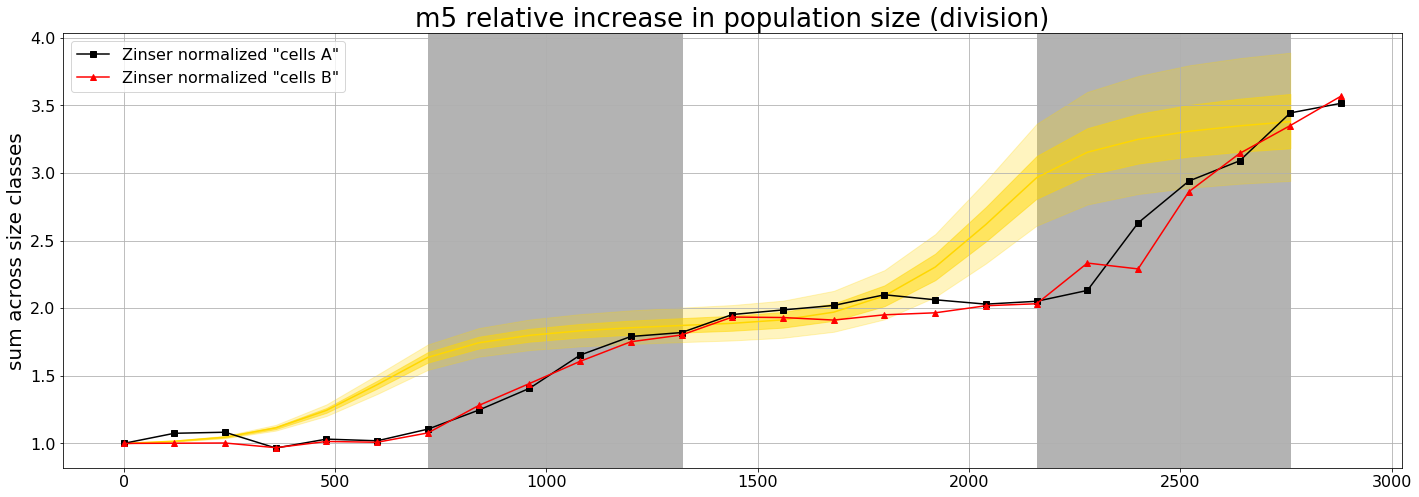

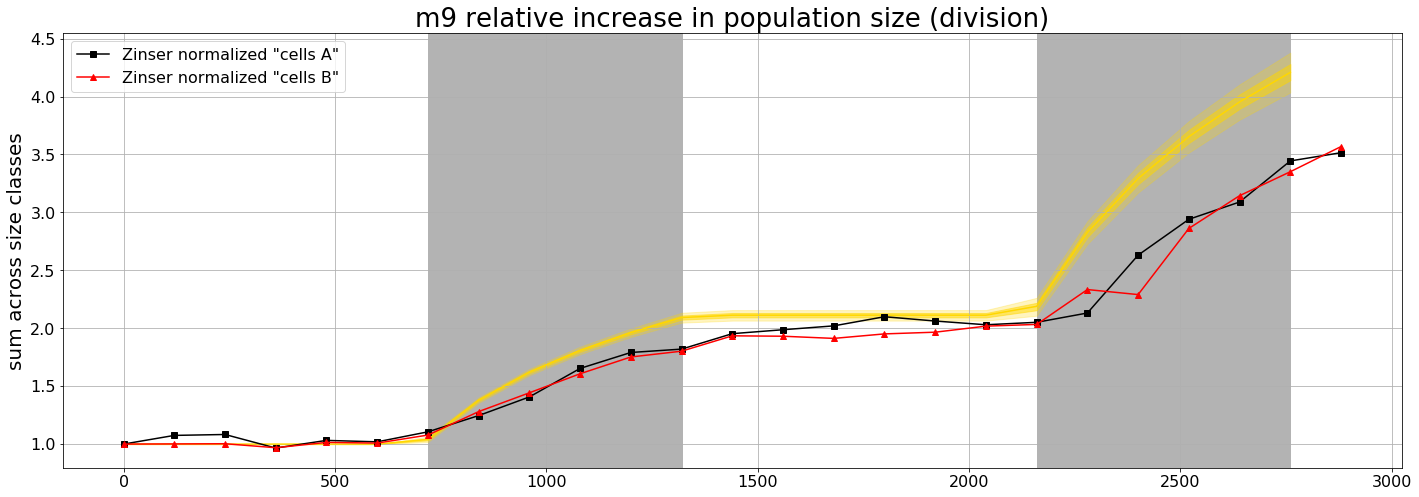

In [9]:
data_fig2a = pd.read_csv('data/Zinser_Figure2A.csv')

t_zinser = data_fig2a['exper time'] * 60
a_norm = data_fig2a['cells A'].copy()
a_norm /= a_norm[0]
b_norm = data_fig2a['cells B'].copy()
b_norm /= b_norm[0]
ab_mean_norm = 0.5*(data_fig2a['cells A'].values/data_fig2a['cells A'].values[0] + 
                    data_fig2a['cells B'].values/data_fig2a['cells B'].values[0])

colors = {'model':'darkred', 'obs':'0.1'}

norm = mpl.colors.Normalize(0.0,0.15)
norm_diff = mpl.colors.Normalize(-0.1,0.1)

for dataname in data:
    if 'zinser' in dataname:
        t = data[dataname]['dt']*np.arange(data[dataname]['nt'])
        delta_v = 1.0/data_gridded[dataname]['delta_v_inv']
        v_ext = data[dataname]['v_min'] * 2**(np.arange(data[dataname]['m']+1)*delta_v) 
        v = v_ext[:-1]
        v_width = v_ext[1:] - v_ext[:-1]

        for model,mcmc in mcmcs.items():
        
            qq = np.percentile(np.sum(mcmc[dataname]['mod_obspos'], axis=1), axis=0, q=(5,25,50,75,95))

            fig,ax = plt.subplots(figsize=(24,8))
            ax.fill_between(data[dataname]['t_obs'], qq[0,:], qq[-1,:], alpha=0.25, color='gold')
            ax.fill_between(data[dataname]['t_obs'], qq[1,:], qq[-2,:], alpha=0.5, color='gold')
            ax.plot(data[dataname]['t_obs'], qq[2,:], color='gold')
        
            ax.plot(t_zinser, a_norm, color='black', marker='s', label='Zinser normalized "cells A"')
            ax.plot(t_zinser, b_norm, color='red', marker='^', label='Zinser normalized "cells B"')
            for iday in range(2):
                ax.axvspan(iday*24*60+12*60, iday*24*60+22*60, color='0.7', zorder=0)
            ax.legend()
            ax.grid(True)
            ax.set(ylabel='sum across size classes', title=desc_model[model]+' relative increase in population size (division)')


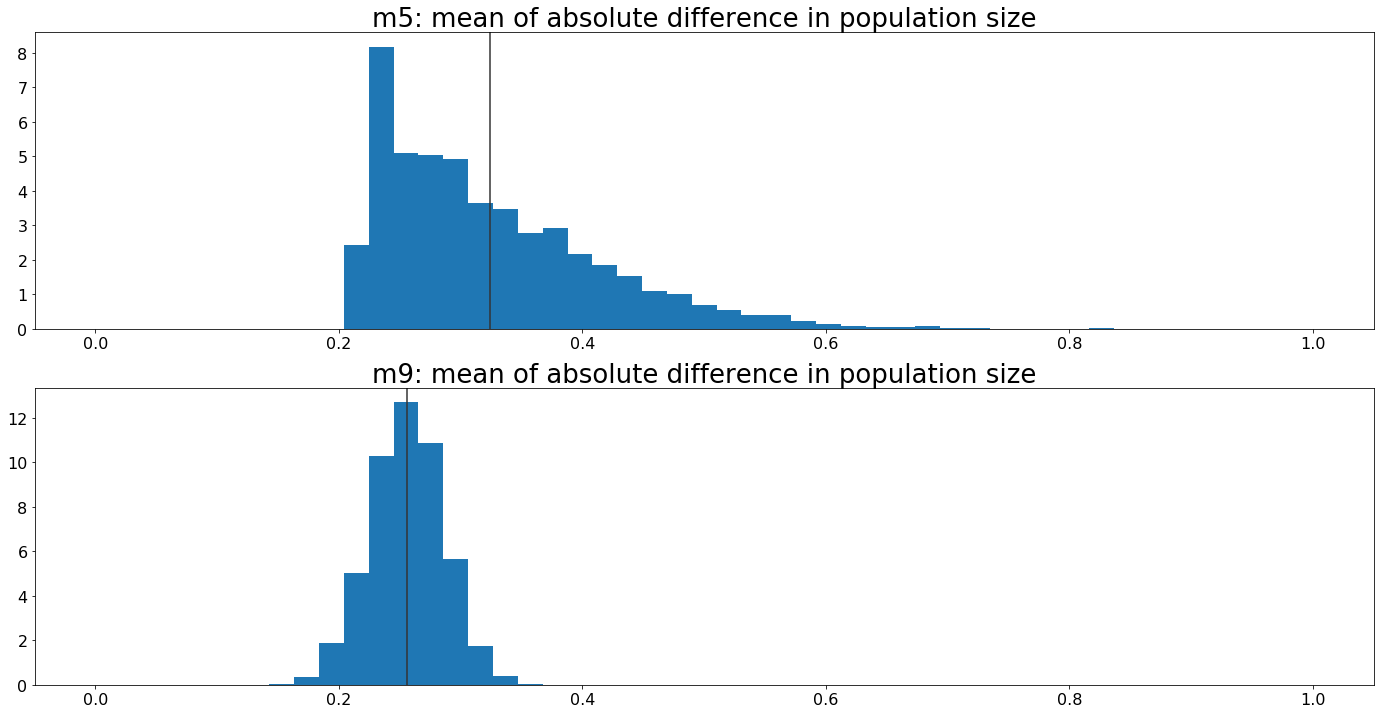

In [10]:
t_zinser = data_fig2a['exper time'] * 60
ab_mean_norm = 0.5*(data_fig2a['cells A'].values/data_fig2a['cells A'].values[0] + 
                    data_fig2a['cells B'].values/data_fig2a['cells B'].values[0])

# make sure the time is right, if not implement something fancier
assert all(t_zinser.values[:-1] == data[dataname]['t_obs'])

for dataname in data:
    if 'zinser' in dataname:
        nrows = len(mcmcs)
        
        fig, axs = plt.subplots(nrows=nrows, figsize=(24,nrows*6))
        
        for ax,model in zip(axs,mcmcs):
            # remove first index, where both are always 1
            e0 = np.mean(np.abs(np.sum(mcmcs[model][dataname]['mod_obspos'], axis=1)[:,1:]-ab_mean_norm[1:-1]), axis=1)
            
            ax.hist(e0, normed=True, bins=np.linspace(0, 1, 50))
            ax.axvline(np.mean(e0), color='0.2')
            ax.set_title(desc_model[model] + ': mean of absolute difference in population size')